# Model Initialization schemes

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms

from yingyang.dataset import YinYangDataset

from new_models import SNN, SNN2
from training import encode_data
import yaml
import random
import snntorch as snn
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns

In [2]:
from dataclasses import dataclass

d_args = yaml.safe_load(open("args.yaml", "r"))


def make_dc(d, name="d_dataclass"):
    @dataclass
    class Wrapped:
        __annotations__ = {k: type(v) for k, v in d.items()}

    Wrapped.__qualname__ = Wrapped.__name__ = name

    return Wrapped

args = make_dc(d_args)(**d_args)
d_args

{'T': 30,
 'alpha': 0.01,
 'batch_size': 128,
 'beta': 2,
 'data_folder': '~/SpiNNCloud/Code/data/',
 'dataset': 'ying_yang',
 'deterministic': False,
 'device': 'cpu',
 'dt': 1,
 'encoding': 'latency_snntorch',
 'epochs': 20,
 'loss_type': 'ce_temporal',
 'lr': 0.001,
 'model': 'snntorch',
 'mu': [1, 1.0],
 'n_hid': 20,
 'optimizer': 'adam',
 'print_freq': 100,
 'resolve_silent': False,
 'seed': 0,
 't_max': None,
 't_min': 2.0,
 'tau_m': 20.0,
 'tau_s': 5.0,
 'use_fluctualtion_init': True,
 'xi': 0.4}

In [110]:
torch.manual_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)

args.dataset = "mnist"
args.encoding = 'rate'

if args.deterministic:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

if args.dataset == "mnist":
    train_dataset = datasets.MNIST(
        args.data_folder, train=True, download=True, transform=transforms.ToTensor()
    )
    test_dataset = datasets.MNIST(
        args.data_folder, train=False, download=True, transform=transforms.ToTensor()
    )
elif args.dataset == "ying_yang":
    train_dataset = YinYangDataset(size=60000, seed=42)
    test_dataset = YinYangDataset(size=10000, seed=40)

else:
    raise ValueError("Invalid dataset name")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=args.batch_size, shuffle=False, drop_last=True
)

model_kwars = {
    "T": args.T,
    "dt": args.dt,
    "tau_m": args.tau_m,
    "tau_s": args.tau_s,
    "mu": args.mu[0],
    "resolve_silent": False
}

n_ins = {"mnist": 784, "ying_yang": 5 if  "latency" in args.encoding else 4}
n_outs = {"mnist": 10, "ying_yang": 3}

args.n_hid = [100]
dims = [n_ins[args.dataset]]
if args.n_hid is not None and isinstance(args.n_hid, list):
    dims.extend(args.n_hid)
elif isinstance(args.n_hid, int):
    dims.append(args.n_hid)
dims.append(n_outs[args.dataset])

In [111]:
snntorch_model1 = SNN2(dims, **model_kwars).to(args.device)
snntorch_model2 = SNN2(dims, **model_kwars).to(args.device)

In [112]:
from initalization_scheme import FluctuationDrivenCenteredNormalInitializer, FluctuationDrivenNormalInitializer

In [113]:
data, targets = next(iter(test_loader))
spikes = encode_data(data, args)
nu = spikes.sum(0).mean() / (spikes.shape[0] * args.dt * 1e-3 )
nu

tensor(82.6471)

In [114]:
from initalization_scheme import _get_epsilon

In [115]:
_get_epsilon('analytical', 20 * 1e-3, 5 * 1e-3, 1 * 1e-3)

(0.005, 0.0005)

In [116]:
initializer = FluctuationDrivenCenteredNormalInitializer(
    sigma_u=2.5, nu=nu, timestep=args.dt * 1e-3
)

In [117]:
initializer.initialize(snntorch_model1)

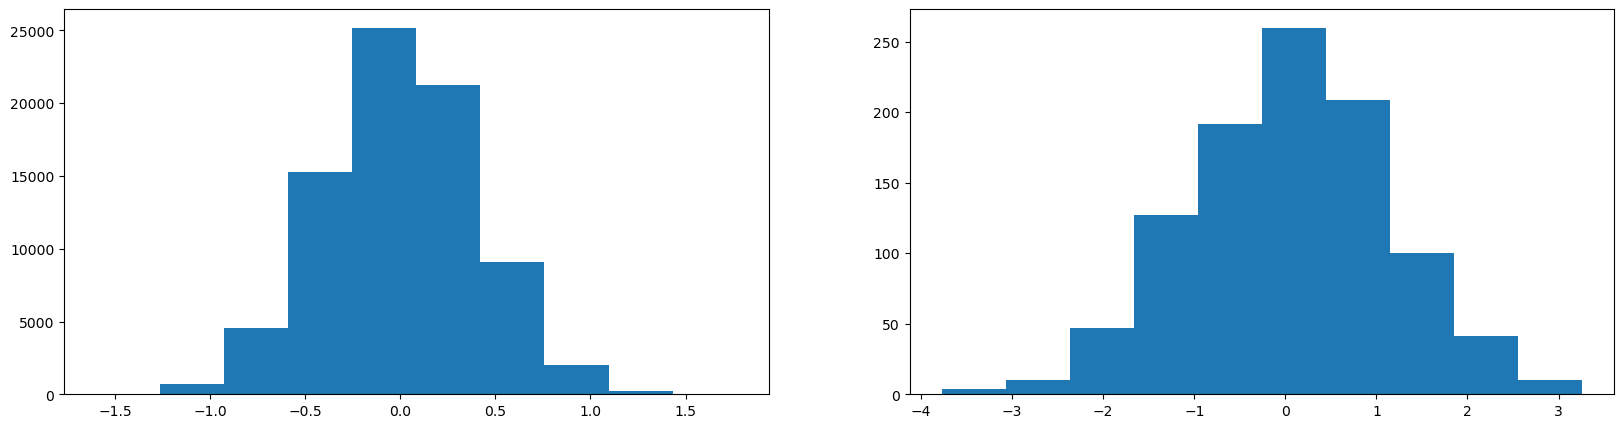

In [118]:
fig, axs = plt.subplots(1, len(snntorch_model1.layers), figsize=(20, 5))
[ax.hist(l.weight.flatten().cpu().data.numpy()) for l, ax in zip(snntorch_model1.layers, axs.flatten())];


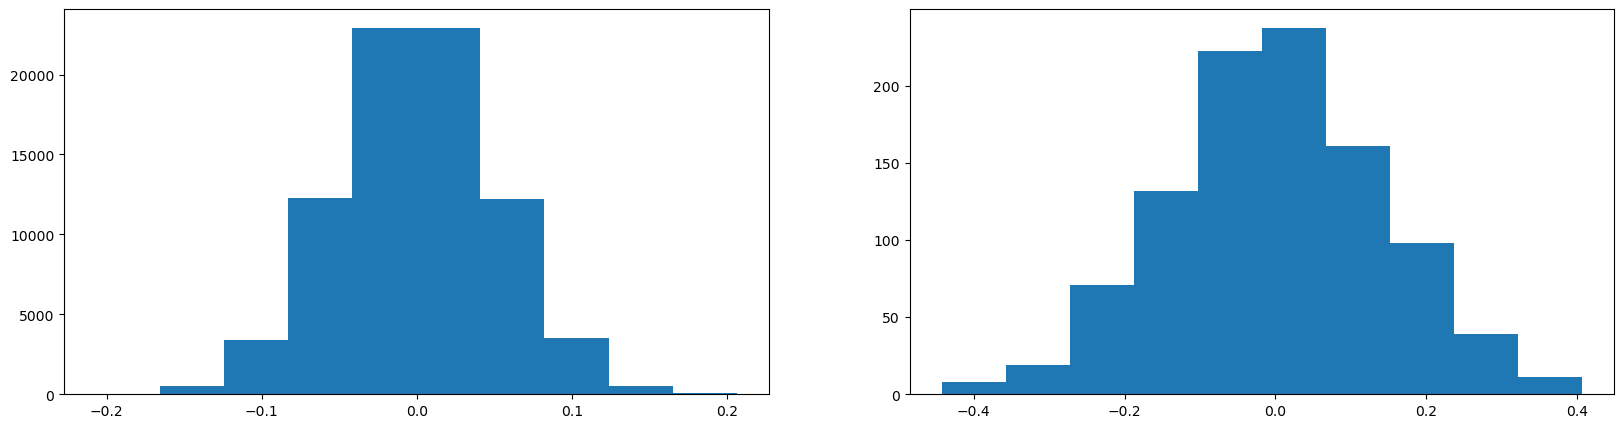

In [119]:
fig, axs = plt.subplots(1, len(snntorch_model2.layers), figsize=(20, 5))
[ax.hist(l.weight.flatten().cpu().data.numpy()) for l, ax in zip(snntorch_model2.layers, axs.flatten())];


In [120]:
counts = [0, 0]
frs = [[], []]
for (data, target), _  in zip(tqdm(test_loader, total=10), range(10)) : 
        
    data, target = data.to(args.device), target.to(args.device)
    spikes_data = encode_data(data, args)
    snn_out1 = snntorch_model1(spikes_data)
    snn_out2 = snntorch_model2(spikes_data)
    counts = [c + out[0].unique(return_counts=True)[1] for c, out in zip(counts, [snn_out1, snn_out2])]
    [f.append(s[0].float().mean()) for f, s in zip(frs, [snn_out1, snn_out2])]
    

  0%|          | 0/10 [00:00<?, ?it/s]

In [121]:
counts

[tensor([377739,   6261]), tensor([384000])]